In [2]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import csv
from io import StringIO

csv_content = """Layer,Depth,Classification,Vs,N
Layer 1,0,Sand,225.62
Layer 1,4,Sand,225.62
Layer 2,4,Sand,192.41
Layer 2,9,Sand,192.41
Layer 3,9,Sand,237.37
Layer 3,15,Sand,237.37
Layer 4,15,Sand,276.56
Layer 4,22.5,Sand,276.56
Layer 5,22.5,Sand,294.72
Layer 5,27,Sand,294.72
Layer 6,27,Clay,294.72
Layer 6,28.5,Clay,294.72
Layer 7,28.5,Sand,294.72
Layer 7,33,Sand,294.72
Layer 8,33,Sand,294.72
Layer 8,39,Sand,294.72
Layer 9,39,Sand,294.72
Layer 9,42,Sand,294.72
Layer 10,42,Sand,294.72
Layer 10,45,Sand,294.72
Layer 11,45,Sand,294.72
Layer 11,49.5,Sand,294.72
Layer 12,49.5,Sand,294.72
Layer 12,63.88,Sand,294.72
Layer 13,63.88,Clay,290.43
Layer 13,65.83,Clay,290.43
Layer 14,65.83,Sand,294.72
Layer 14,73.38,Sand,294.72
"""

Maximum Vs: 294.72 m/s
Depth to Engineering Bedrock: 22.50 m


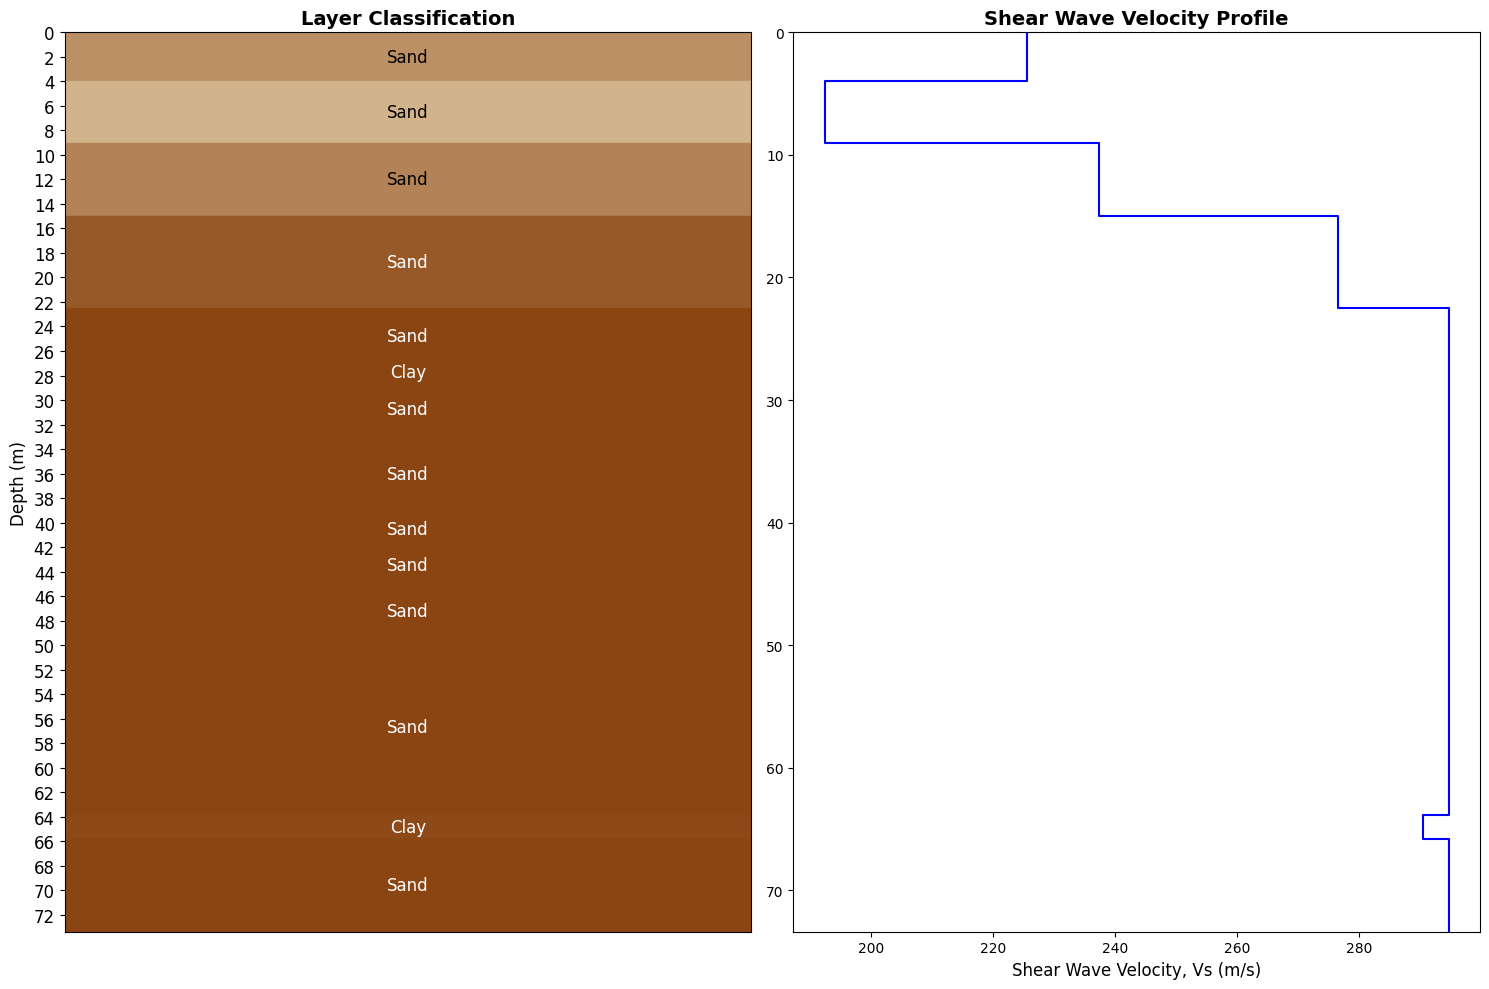

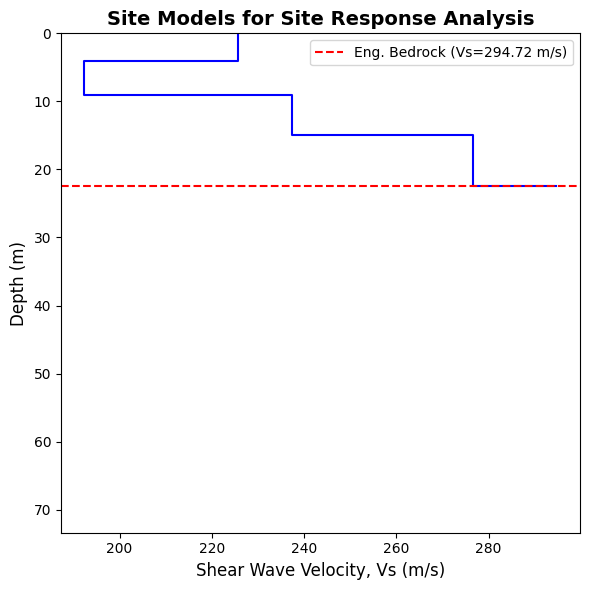

In [ ]:
def get_contrast_text_color(rgb_color):
    """
    Returns 'white' if the color is dark and 'black' if the color is light.
    """
    brightness = 0.299 * rgb_color[0] + 0.587 * rgb_color[1] + 0.114 * rgb_color[2]
    return "white" if brightness < 0.5 else "black"

def plot_layer_classification(ax, layer_boundaries, layer_n, layer_vs, layer_classification, has_n_data):
    """
    Plots the layer classification as colored blocks along the depth axis.
    
    - If has_n_data is True, color each layer by its N-value (larger N => darker).
    - Otherwise, color by the layer's Vs value (larger Vs => darker).
    
    Uses a brown gradient from light (#d2b48c) to dark (#8B4513).
    """
    if has_n_data:
        min_val = min(layer_n)
        max_val = max(layer_n)
        data_array = layer_n
    else:
        min_val = min(layer_vs)
        max_val = max(layer_vs)
        data_array = layer_vs
    
    norm = mcolors.Normalize(min_val, max_val)
    brown_cmap = LinearSegmentedColormap.from_list("brown_shades", ["#d2b48c", "#8B4513"])
    
    for i, ((top, bottom), classification) in enumerate(zip(layer_boundaries, layer_classification)):
        val = data_array[i]
        layer_color = brown_cmap(norm(val))
        ax.fill_betweenx([top, bottom], 0, 1, color=layer_color)
        
        text_color = get_contrast_text_color(layer_color)
        mid_depth = (top + bottom) / 2
        ax.text(
            0.5,
            mid_depth,
            classification,
            fontsize=12,  # Match the other subplots
            ha='center',
            va='center',
            color=text_color
        )
    
    overall_top = layer_boundaries[0][0]
    overall_bottom = layer_boundaries[-1][1]
    ax.set_ylim(overall_bottom, overall_top)  # invert so depth increases downward
    ax.set_xlim(0, 1)
    ax.set_xticks([])
    
    # Force integer ticks at every 2 meters of depth
    ax.set_yticks(np.arange(int(overall_top), int(overall_bottom) + 1, 2))
    ax.tick_params(axis='y', labelsize=12)  # Match the other subplots
    
    ax.set_ylabel("Depth (m)", fontsize=12)
    ax.set_title("Layer Classification", fontsize=14, fontweight='bold')

def plot_shearwave_velocity(ax, depth, vs, title="Shear Wave Velocity Profile"):
    """
    Plots the shear wave velocity profile as a step plot (no markers).
    """
    ax.step(vs, depth, where='post', color='blue', linestyle='-')
    ax.set_ylim(max(depth), min(depth))  # invert y-axis
    ax.margins(y=0.1)
    
    ax.set_xlabel("Shear Wave Velocity, Vs (m/s)", fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold')

def plot_n_values(ax, depth, n_values):
    """
    Plots the N-values as a step plot (no markers).
    """
    ax.step(n_values, depth, where='post', color='blue', linestyle='-')
    ax.set_ylim(max(depth), min(depth))
    ax.margins(y=0.1)
    
    ax.set_xlabel("N-Values", fontsize=12)
    ax.set_title("Depth vs N-Values", fontsize=14, fontweight='bold')

def truncate_profile(depth, vs, bedrock_depth):
    """
    Returns arrays of depth and vs only for depths less than or equal to bedrock_depth.
    """
    truncated_depth = []
    truncated_vs = []
    for d, v in zip(depth, vs):
        if d <= bedrock_depth:
            truncated_depth.append(d)
            truncated_vs.append(v)
        else:
            break
    return truncated_depth, truncated_vs

def main():
    # Example CSV data from the first cell (replace with your own).
    csv_file = StringIO(csv_content)
    reader = csv.DictReader(csv_file)
    rows = list(reader)
    
    depth_all = []
    vs_all = []
    n_all = []
    has_n_data = True  # Will be set to False if any N-value is missing or invalid.
    
    for row in rows:
        depth_val = float(row["Depth"]) if row["Depth"] else None
        vs_val = float(row["Vs"]) if row["Vs"] else None
        depth_all.append(depth_val)
        vs_all.append(vs_val)
        
        n_str = row["N"].strip() if row["N"] else ""
        if n_str == "":
            has_n_data = False
            n_all.append(None)
        else:
            try:
                n_val = float(n_str)
                n_all.append(n_val)
            except ValueError:
                has_n_data = False
                n_all.append(None)
    
    # Build layer boundaries (every 2 lines define the top and bottom of a layer)
    layer_boundaries = []
    layer_n = []
    layer_vs = []
    layer_classification = []
    
    for i in range(0, len(rows), 2):
        top = float(rows[i]["Depth"])
        bottom = float(rows[i+1]["Depth"])
        layer_boundaries.append((top, bottom))
        
        if has_n_data:
            n_val = float(rows[i]["N"])
        else:
            n_val = 1.0  # fallback
        vs_val_layer = float(rows[i]["Vs"])
        
        layer_n.append(n_val)
        layer_vs.append(vs_val_layer)
        layer_classification.append(rows[i]["Classification"])
    
    #################################
    # 1) Find maximum Vs & bedrock
    #################################
    max_vs = max(vs_all)
    max_vs_index = vs_all.index(max_vs)
    max_vs_depth = depth_all[max_vs_index]
    
    # Engineering bedrock is defined as the top of the layer that contains the max Vs.
    engineering_bedrock_depth = None
    for (top, bottom) in layer_boundaries:
        if top <= max_vs_depth < bottom:
            engineering_bedrock_depth = top
            break
    
    print(f"Maximum Vs: {max_vs:.2f} m/s")
    if engineering_bedrock_depth is not None:
        print(f"Depth to Engineering Bedrock: {engineering_bedrock_depth:.2f} m")
    else:
        print("Could not identify engineering bedrock layer from the data.")
    
    ##################################################
    # 2) PLOT THE ORIGINAL PROFILES (3-SUBPLOT LAYOUT)
    ##################################################
    # Increase the figure size to reduce label overlap
    if has_n_data:
        fig, axes = plt.subplots(1, 3, figsize=(15, 10), gridspec_kw={'width_ratios': [1, 2, 2]})
        plot_layer_classification(axes[0], layer_boundaries, layer_n, layer_vs, layer_classification, has_n_data=True)
        plot_shearwave_velocity(axes[1], depth_all, vs_all, "Shear Wave Velocity Profile")
        plot_n_values(axes[2], depth_all, n_all)
    else:
        fig, axes = plt.subplots(1, 2, figsize=(15, 10))
        plot_layer_classification(axes[0], layer_boundaries, layer_n, layer_vs, layer_classification, has_n_data=False)
        plot_shearwave_velocity(axes[1], depth_all, vs_all, "Shear Wave Velocity Profile")
    
    plt.tight_layout()
    plt.show()
    
    ###############################################
    # 3) PLOT THE SITE MODEL (SECOND FIGURE)
    ###############################################
    # For the site model, we display the full depth range on the y-axis,
    # but the blue Vs step plot is truncated at the engineering bedrock.
    if engineering_bedrock_depth is not None:
        truncated_depth, truncated_vs = truncate_profile(depth_all, vs_all, engineering_bedrock_depth)
    else:
        truncated_depth, truncated_vs = depth_all, vs_all  # Fallback if no bedrock identified
    
    fig2, ax2 = plt.subplots(figsize=(6, 6))
    # Plot the truncated Vs profile (blue line stops at bedrock)
    plot_shearwave_velocity(ax2, truncated_depth, truncated_vs, "Site Models for Site Response Analysis")
    
    # Reset y-axis to show full depth range from the original profile
    ax2.set_ylim(max(depth_all), min(depth_all))
    ax2.set_ylabel("Depth (m)", fontsize=12)
    
    # Draw a horizontal red dashed line at the engineering bedrock depth
    if engineering_bedrock_depth is not None:
        ax2.axhline(y=engineering_bedrock_depth, color='red', linestyle='--',
                    label=f'Eng. Bedrock (Vs={max_vs:.2f} m/s)')
        ax2.legend(loc='best')
    
    plt.tight_layout()
    plt.show()

# Run main when this cell is executed
main()